# Notebook de comparaison ARI

Initialisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/clean.csv')

Sélection des features numériques pour la normalisation

In [2]:
numeric_features = ['total_orders', 'avg_delivery_time_days', 'days_since_last_order', 
                    'total_spent', 'avg_review_score', 'avg_delivery_delay_days', 
                    'max_delivery_delay_days', 'has_comment', 'last_payment_installments']

Normalisation des features

In [3]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numeric_features]), 
                             columns=[f"{col}_normalized" for col in numeric_features])

# Combinaison des données normalisées avec le dataframe original
df = pd.concat([df.reset_index(drop=True), df_normalized], axis=1)

Sélection des features normalisées pour le clustering

In [4]:
features_optimal = [col for col in df.columns if col.endswith('_normalized')]
X_optimal = df[features_optimal]

Réentraînement du modèle KMeans optimal

In [5]:
kmeans_optimal = KMeans(n_clusters=6, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_optimal)

Création des données dégradées

In [6]:
df_degraded = df.copy()
df_degraded['days_since_last_order'] += 365

Normalisation des données dégradées avec le même scaler

In [7]:
df_degraded_normalized = pd.DataFrame(scaler.transform(df_degraded[numeric_features]), 
                                      columns=[f"{col}_normalized" for col in numeric_features])
df_degraded = pd.concat([df_degraded.reset_index(drop=True), df_degraded_normalized], axis=1)

Clustering sur les données dégradées

In [8]:
X_degraded = df_degraded[features_optimal]
kmeans_degraded = KMeans(n_clusters=6, random_state=42)
clusters_degraded = kmeans_degraded.fit_predict(X_degraded)

Calcul du score ARI

In [9]:
ari_score = adjusted_rand_score(clusters_optimal, clusters_degraded)
print(f"\nScore ARI entre le modèle optimal et le modèle dégradé : {ari_score}")


Score ARI entre le modèle optimal et le modèle dégradé : 0.99720789228998


Matrice de confusion

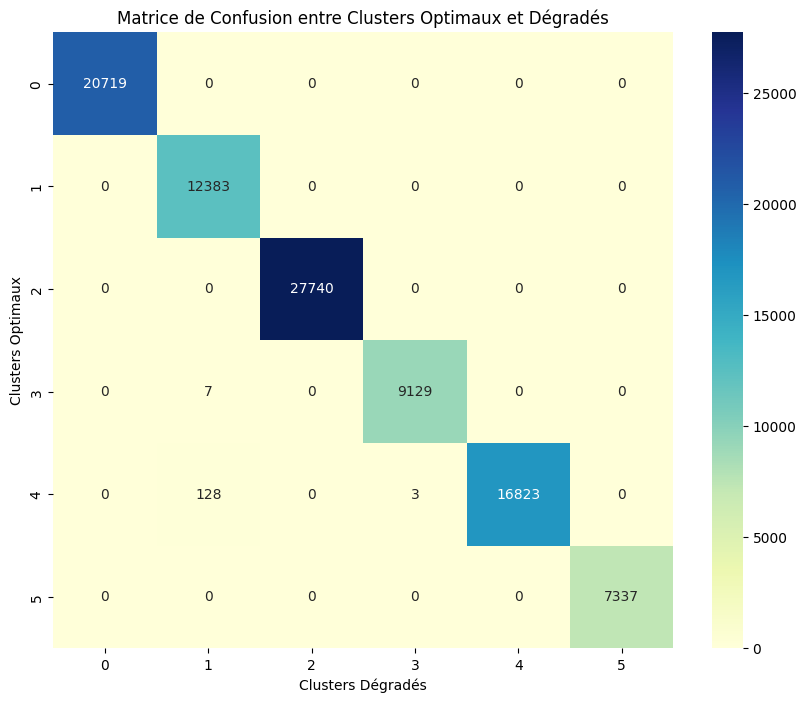

In [10]:
confusion_matrix = pd.crosstab(clusters_optimal, clusters_degraded, 
                               rownames=['Clusters Optimaux'], 
                               colnames=['Clusters Dégradés'])
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Matrice de Confusion entre Clusters Optimaux et Dégradés')
plt.show()

Analyse des changements de clusters

In [11]:
df['cluster_optimal'] = clusters_optimal
df['cluster_degraded'] = clusters_degraded
df['cluster_changed'] = df['cluster_optimal'] != df['cluster_degraded']
print("\nPourcentage de clients ayant changé de cluster :")
print(df['cluster_changed'].mean() * 100)


Pourcentage de clients ayant changé de cluster :
0.1463895872450116


Analyse des caractéristiques pour les clients ayant changé de cluster

In [12]:
changed_clusters = df[df['cluster_changed']]
unchanged_clusters = df[~df['cluster_changed']]
for feature in features_optimal:
    print(f"\nMoyenne de {feature} :")
    print(f"Clients ayant changé de cluster : {changed_clusters[feature].mean():.2f}")
    print(f"Clients n'ayant pas changé de cluster : {unchanged_clusters[feature].mean():.2f}")


Moyenne de total_orders_normalized :
Clients ayant changé de cluster : 0.00
Clients n'ayant pas changé de cluster : 0.00

Moyenne de avg_delivery_time_days_normalized :
Clients ayant changé de cluster : 0.07
Clients n'ayant pas changé de cluster : 0.06

Moyenne de days_since_last_order_normalized :
Clients ayant changé de cluster : 0.39
Clients n'ayant pas changé de cluster : 0.34

Moyenne de total_spent_normalized :
Clients ayant changé de cluster : 0.01
Clients n'ayant pas changé de cluster : 0.01

Moyenne de avg_review_score_normalized :
Clients ayant changé de cluster : 0.70
Clients n'ayant pas changé de cluster : 0.79

Moyenne de avg_delivery_delay_days_normalized :
Clients ayant changé de cluster : 0.00
Clients n'ayant pas changé de cluster : 0.00

Moyenne de max_delivery_delay_days_normalized :
Clients ayant changé de cluster : 0.00
Clients n'ayant pas changé de cluster : 0.00

Moyenne de has_comment_normalized :
Clients ayant changé de cluster : 1.00
Clients n'ayant pas changé

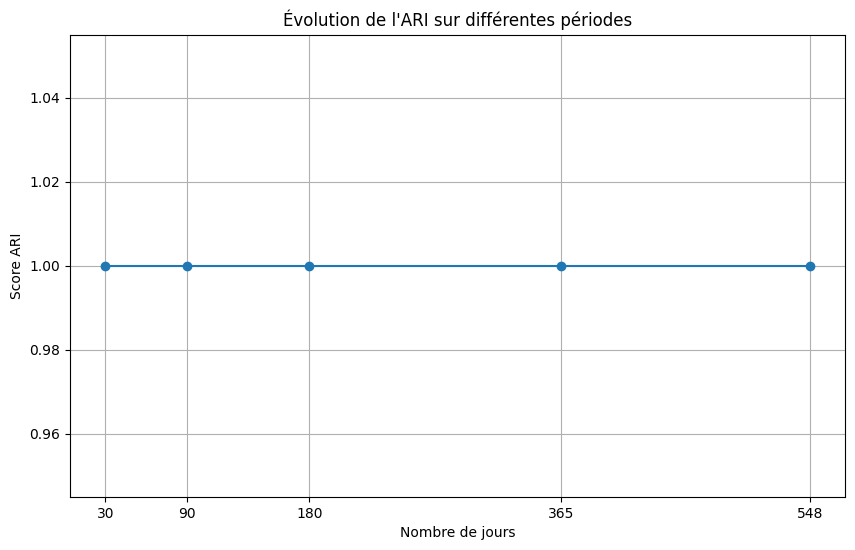

Période: 30 jours, Score ARI: 1.0000
Période: 90 jours, Score ARI: 1.0000
Période: 180 jours, Score ARI: 1.0000
Période: 365 jours, Score ARI: 1.0000
Période: 548 jours, Score ARI: 1.0000


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def calculate_ari_evolution(df, features, n_clusters, periods):
    scaler = MinMaxScaler()
    X_original = scaler.fit_transform(df[features])
    
    kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_original = kmeans_original.fit_predict(X_original)
    
    ari_scores = []
    
    for period in periods:
        df_degraded = df.copy()
        df_degraded['days_since_last_order'] += period
        
        X_degraded = scaler.transform(df_degraded[features])
        
        kmeans_degraded = KMeans(n_clusters=n_clusters, random_state=42)
        clusters_degraded = kmeans_degraded.fit_predict(X_degraded)
        
        ari = adjusted_rand_score(clusters_original, clusters_degraded)
        ari_scores.append(ari)
    
    return ari_scores

# Définir les périodes à analyser (en jours)
periods = [30, 90, 180, 365, 548]  # 1 mois, 3 mois, 6 mois, 1 an, 18 mois

# Calculer l'ARI pour chaque période
ari_scores = calculate_ari_evolution(df, features_optimal, n_clusters=6, periods=periods)

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(periods, ari_scores, marker='o')
plt.title("Évolution de l'ARI sur différentes périodes")
plt.xlabel("Nombre de jours")
plt.ylabel("Score ARI")
plt.xticks(periods)
plt.grid(True)
plt.show()

# Afficher les scores ARI
for period, score in zip(periods, ari_scores):
    print(f"Période: {period} jours, Score ARI: {score:.4f}")